# Notebook demonstrating fitting of $hrz0$ to site data
The below code shows how to use data from fixed-tilt experiments to compute the free parameter $hrz0$. The dust distribution is currently assumed and its parameters are defined in the file `parameters_qut_experiments.xlsx`.

In [1]:
import numpy as np
import soiling_model.base_models as smb
import soiling_model.fitting as smf
import soiling_model.utilities as smu
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.stats import norm
rcParams['figure.figsize'] = (5, 5)
from analysis_scripts.paper_specific_utilities import plot_for_paper, daily_soiling_rate, fit_quality_plots, summarize_fit_quality
import scipy.stats as sps
# %matplotlib qt

ls_save_file = "./results/ls_fitting_results_qut"
sp_save_file = "./results/sp_fitting_results_qut"
cm_save_file = "./results/cm_fitting_results_qut"
reflectometer_incidence_angle = 15 # angle of incidence of reflectometer
reflectometer_acceptance_angle = 12.5e-3 # half acceptance angle of reflectance measurements
k_factor = 2.404 # calibration factor for TSP measurements in experiments
second_surf = True # True if using the second-surface model. Otherwise, use first-surface
d = "data/qut/" # directory of parameter files (be sure to follow naming convention)
test_time_at_end = [0,0,0,0] # amount of test time to leave at the end of each file
parameter_file = d+"parameters_qut_experiments.xlsx"

## Load in data and divide into training and testing

Specify mirrors for training, the k-factors of the dust measurements (if any), and the type of dust measurement (PMX or TSP).

In [2]:
train_experiments = [0,1] # indices for training experiments from 0 to len(files)-1
train_mirrors = ["Mirror_1"] # which mirrors within the experiments are used for training
files_experiment,training_intervals,mirror_name_list,all_mirrors = smu.get_training_data(d,"experiment_")
dust_type = "TSP"

extract = lambda x,ind: [x[ii] for ii in ind]
files_experiment_train = extract(files_experiment,train_experiments)
training_intervals = extract(training_intervals,train_experiments)
t = [t for t in train_experiments]
training_string = "Training: "+str(train_mirrors)+", Exp: "+str(t)

Instantiate model and load in training data

In [3]:
imodel = smf.SemiPhysical(parameter_file)
sim_data_train = smb.SimulationInputs( files_experiment_train,
                                        k_factors=k_factor,
                                        dust_type=dust_type
                                        )
reflect_data_train = smb.ReflectanceMeasurements(  files_experiment_train,
                                                    sim_data_train.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=reflectometer_incidence_angle,
                                                    reflectometer_acceptance_angle=reflectometer_acceptance_angle,
                                                    import_tilts=True,
                                                    imported_column_names=train_mirrors
                                                    )



Loading data from data/qut/parameters_qut_experiments.xlsx ... 

Importing constants
Importing site data from data/qut/experiment_20170807_20170811_cinque.xlsx, dust_type=TSP, length=4 days
Importing AirTemp data as air_temp...
Importing WindSpeed data as wind_speed...
Importing tsp data...
Simulation length for data/qut/experiment_20170807_20170811_cinque.xlsx: 4 days
Importing site data from data/qut/experiment_20170828_20170901_cinque.xlsx, dust_type=TSP, length=3 days
Importing AirTemp data as air_temp...
Importing WindSpeed data as wind_speed...
Importing tsp data...
Simulation length for data/qut/experiment_20170828_20170901_cinque.xlsx: 3 days
Importing dust properties for each experiment
Loading source (normalized) intensity from data/qut/experiment_20170807_20170811_cinque.xlsx
Loading source (normalized) intensity from data/qut/experiment_20170828_20170901_cinque.xlsx


Trim training data to specified ranges. The second trim ensures that the weather variables stop at the limits of the reflectance data

In [4]:
            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                training_intervals 
                                                            )
                                                            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                "reflectance_data" 
                                                            )


Load in the total data

In [5]:

sim_data_total = smb.SimulationInputs( files_experiment,
                                        k_factors=k_factor,
                                        dust_type=dust_type
                                        )

reflect_data_total = smb.ReflectanceMeasurements(  files_experiment,
                                                    sim_data_total.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=reflectometer_incidence_angle,
                                                    reflectometer_acceptance_angle=reflectometer_acceptance_angle,
                                                    import_tilts=True,
                                                    imported_column_names=None
                                                    )


Importing site data from data/qut/experiment_20170807_20170811_cinque.xlsx, dust_type=TSP, length=4 days
Importing AirTemp data as air_temp...
Importing WindSpeed data as wind_speed...
Importing tsp data...
Simulation length for data/qut/experiment_20170807_20170811_cinque.xlsx: 4 days
Importing site data from data/qut/experiment_20170828_20170901_cinque.xlsx, dust_type=TSP, length=3 days
Importing AirTemp data as air_temp...
Importing WindSpeed data as wind_speed...
Importing tsp data...
Simulation length for data/qut/experiment_20170828_20170901_cinque.xlsx: 3 days
Importing site data from data/qut/experiment_20170905_20170913_cinque.xlsx, dust_type=TSP, length=8 days
Importing AirTemp data as air_temp...
Importing WindSpeed data as wind_speed...
Importing tsp data...
Simulation length for data/qut/experiment_20170905_20170913_cinque.xlsx: 8 days
Importing site data from data/qut/experiment_20170915_20170921_cinque.xlsx, dust_type=TSP, length=6 days
Importing AirTemp data as air_temp

c:\Users\cholette\OneDrive - Queensland University of Technology\ASTRI\python_soiling_model\HelioSoil\soiling_model\utilities.py:188: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[4].legend(fontsize=lgd_size)


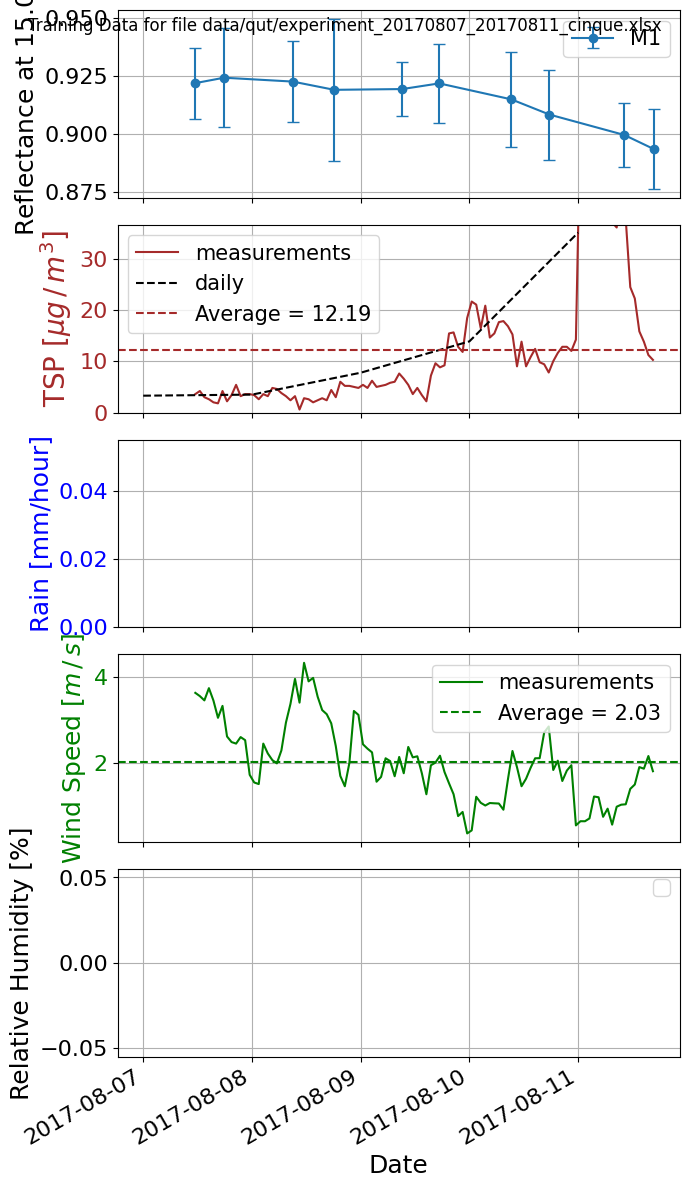

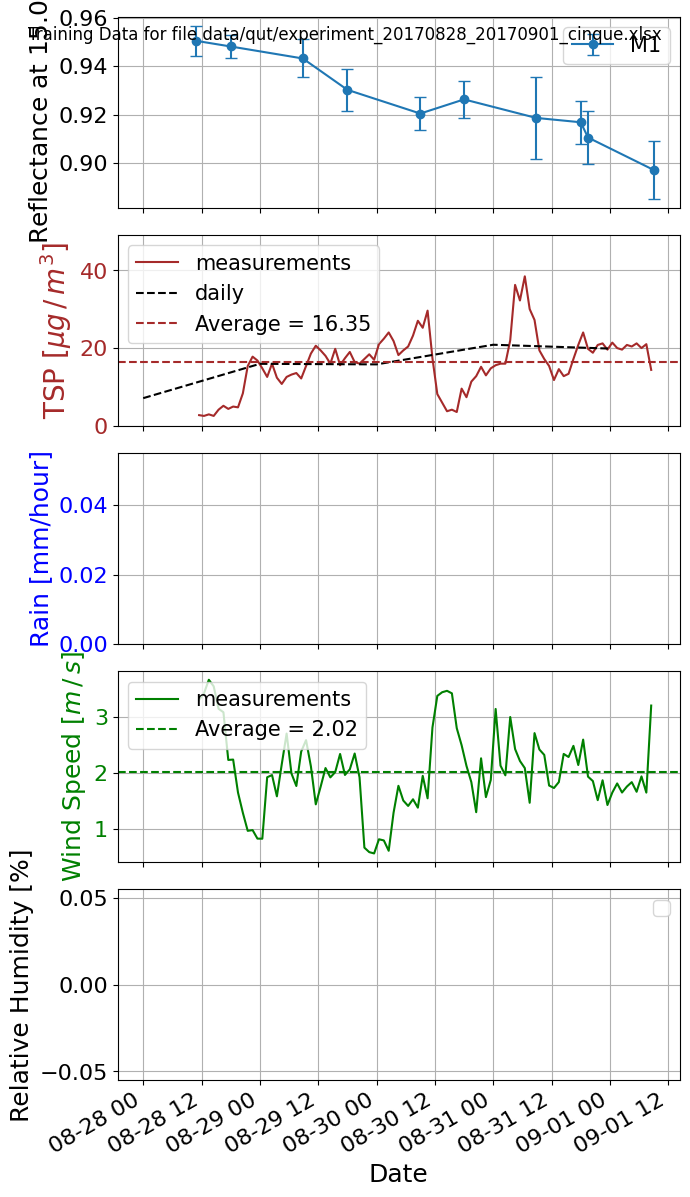

In [6]:
for ii,experiment in enumerate(files_experiment_train):
    fig,ax = smu.plot_experiment_data(sim_data_train,reflect_data_train,ii)
    fig.suptitle(f"Training Data for file {experiment}")

### Compute extinction weights for both simulation datasets and plot. 
Note that the extinction weights depend only on the refractive index. If the refractive index is the same for all experiments, all extinction weights will be the same (and the computation will be faster.)

In [7]:
imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
imodel.helios.compute_extinction_weights(sim_data_train,imodel.loss_model,verbose=True)

Setting tilts for 2 experiments
Second surface model
Second surface model
Loss Model is mie. Computing extinction coefficients ... 


File 0:   0%|          | 0/1 [00:00<?, ?it/s, acceptance angle 12.50 mrad]

	 Acceptance angle cosine = 0.999922


File 1:   0%|          | 0/1 [00:00<?, ?it/s, acceptance angle 12.50 mrad]

... Done!


Plot extinction weights and save for later, since extinction weights are the same for all files in this example.

(<Figure size 500x700 with 4 Axes>,
 array([[<Axes: xlabel='Diameter $D$ [$\\mu$m]', ylabel='dN/dlog$D$ [# m$^{-3}$]'>],
        [<Axes: xlabel='Diameter $D$ [$\\mu$m]', ylabel='dN/dlog$D$ [# m$^{-3}$]'>]],
       dtype=object),
 [<Axes: ylabel='dm/dlog$D$ [µg m$^{-3}$]'>,
  <Axes: ylabel='dm/dlog$D$ [µg m$^{-3}$]'>])

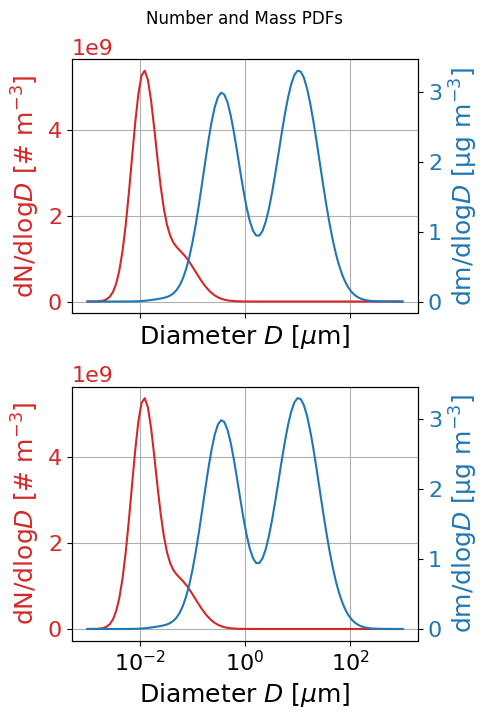

In [8]:
sim_data_train.dust.plot_distributions(figsize=(5,7))

[<Axes: title={'center': 'Area PDF'}, xlabel='Diameter $D$ [$\\mu$m]', ylabel='dA/dlog$D$ [m$^2$ m$^{-3}$]'>,
 <Axes: title={'center': 'Area PDF'}, xlabel='Diameter $D$ [$\\mu$m]', ylabel='dA/dlog$D$ [m$^2$ m$^{-3}$]'>]

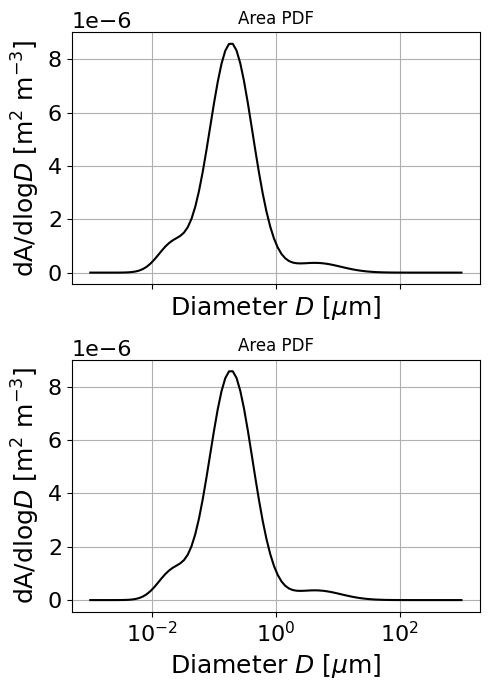

In [9]:
sim_data_train.dust.plot_area_distribution(figsize=(5,7))

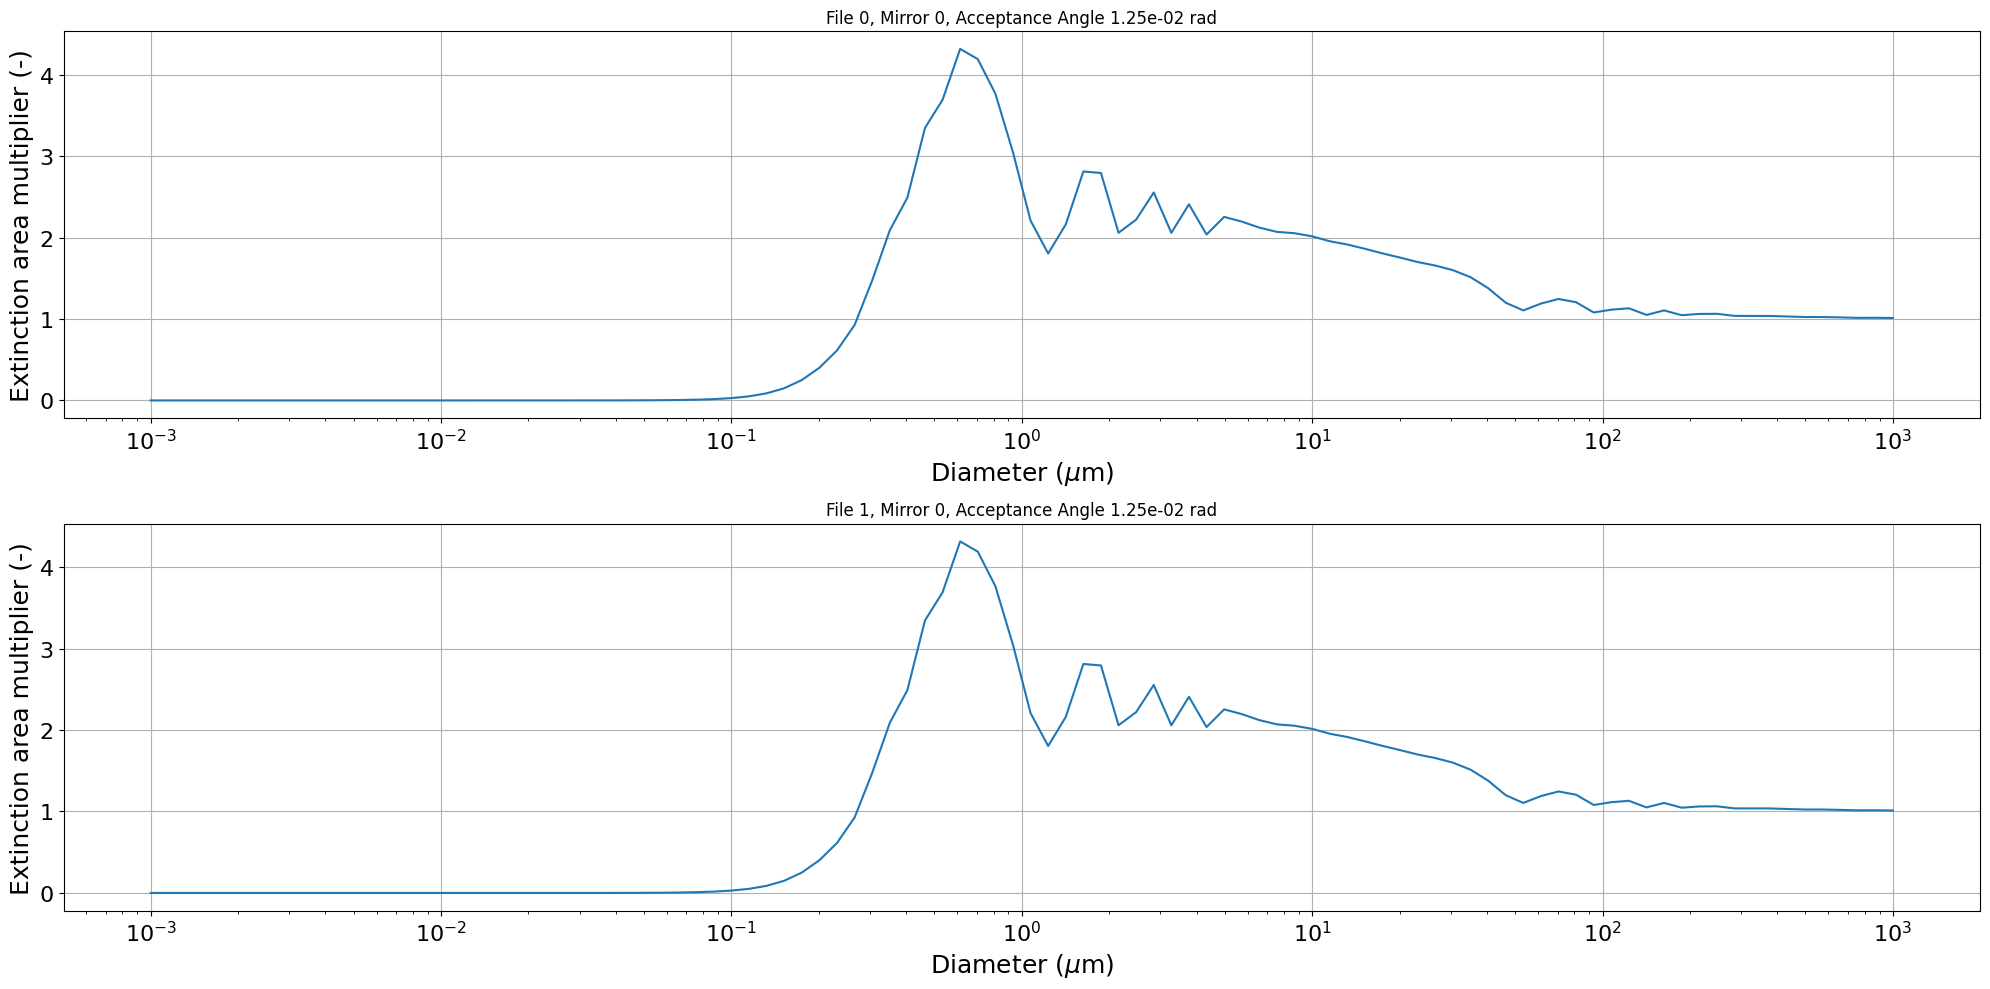

In [10]:
imodel.helios.plot_extinction_weights(sim_data_train,fig_kwargs={'figsize':(20,10)})
ext_weights = imodel.helios.extinction_weighting[0].copy()

# Fit non-stochastic model

In [11]:
hrz0_multi,sse_multi = imodel.fit_least_squares(sim_data_train,reflect_data_train)
imodel.update_model_parameters(hrz0_multi)
imodel.save(ls_save_file,
            training_simulation_data=sim_data_train,
            training_reflectance_data=reflect_data_train)

Fitting parameters with least squares ...
... done! 
 estimated parameter is = 2.2286380015696627


Set extinction coefficients. Instead of computing, we set them directly using set_extinction_coefficients since we know that they are all the same (because the dust and acceptance angles of the measurement are all the same).

In [12]:
imodel.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(sim_data_total,imodel.loss_model,verbose=True) 

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)


Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


No value for hrz0 supplied. Using value in self.hrz0 = 2.2286380015696627.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


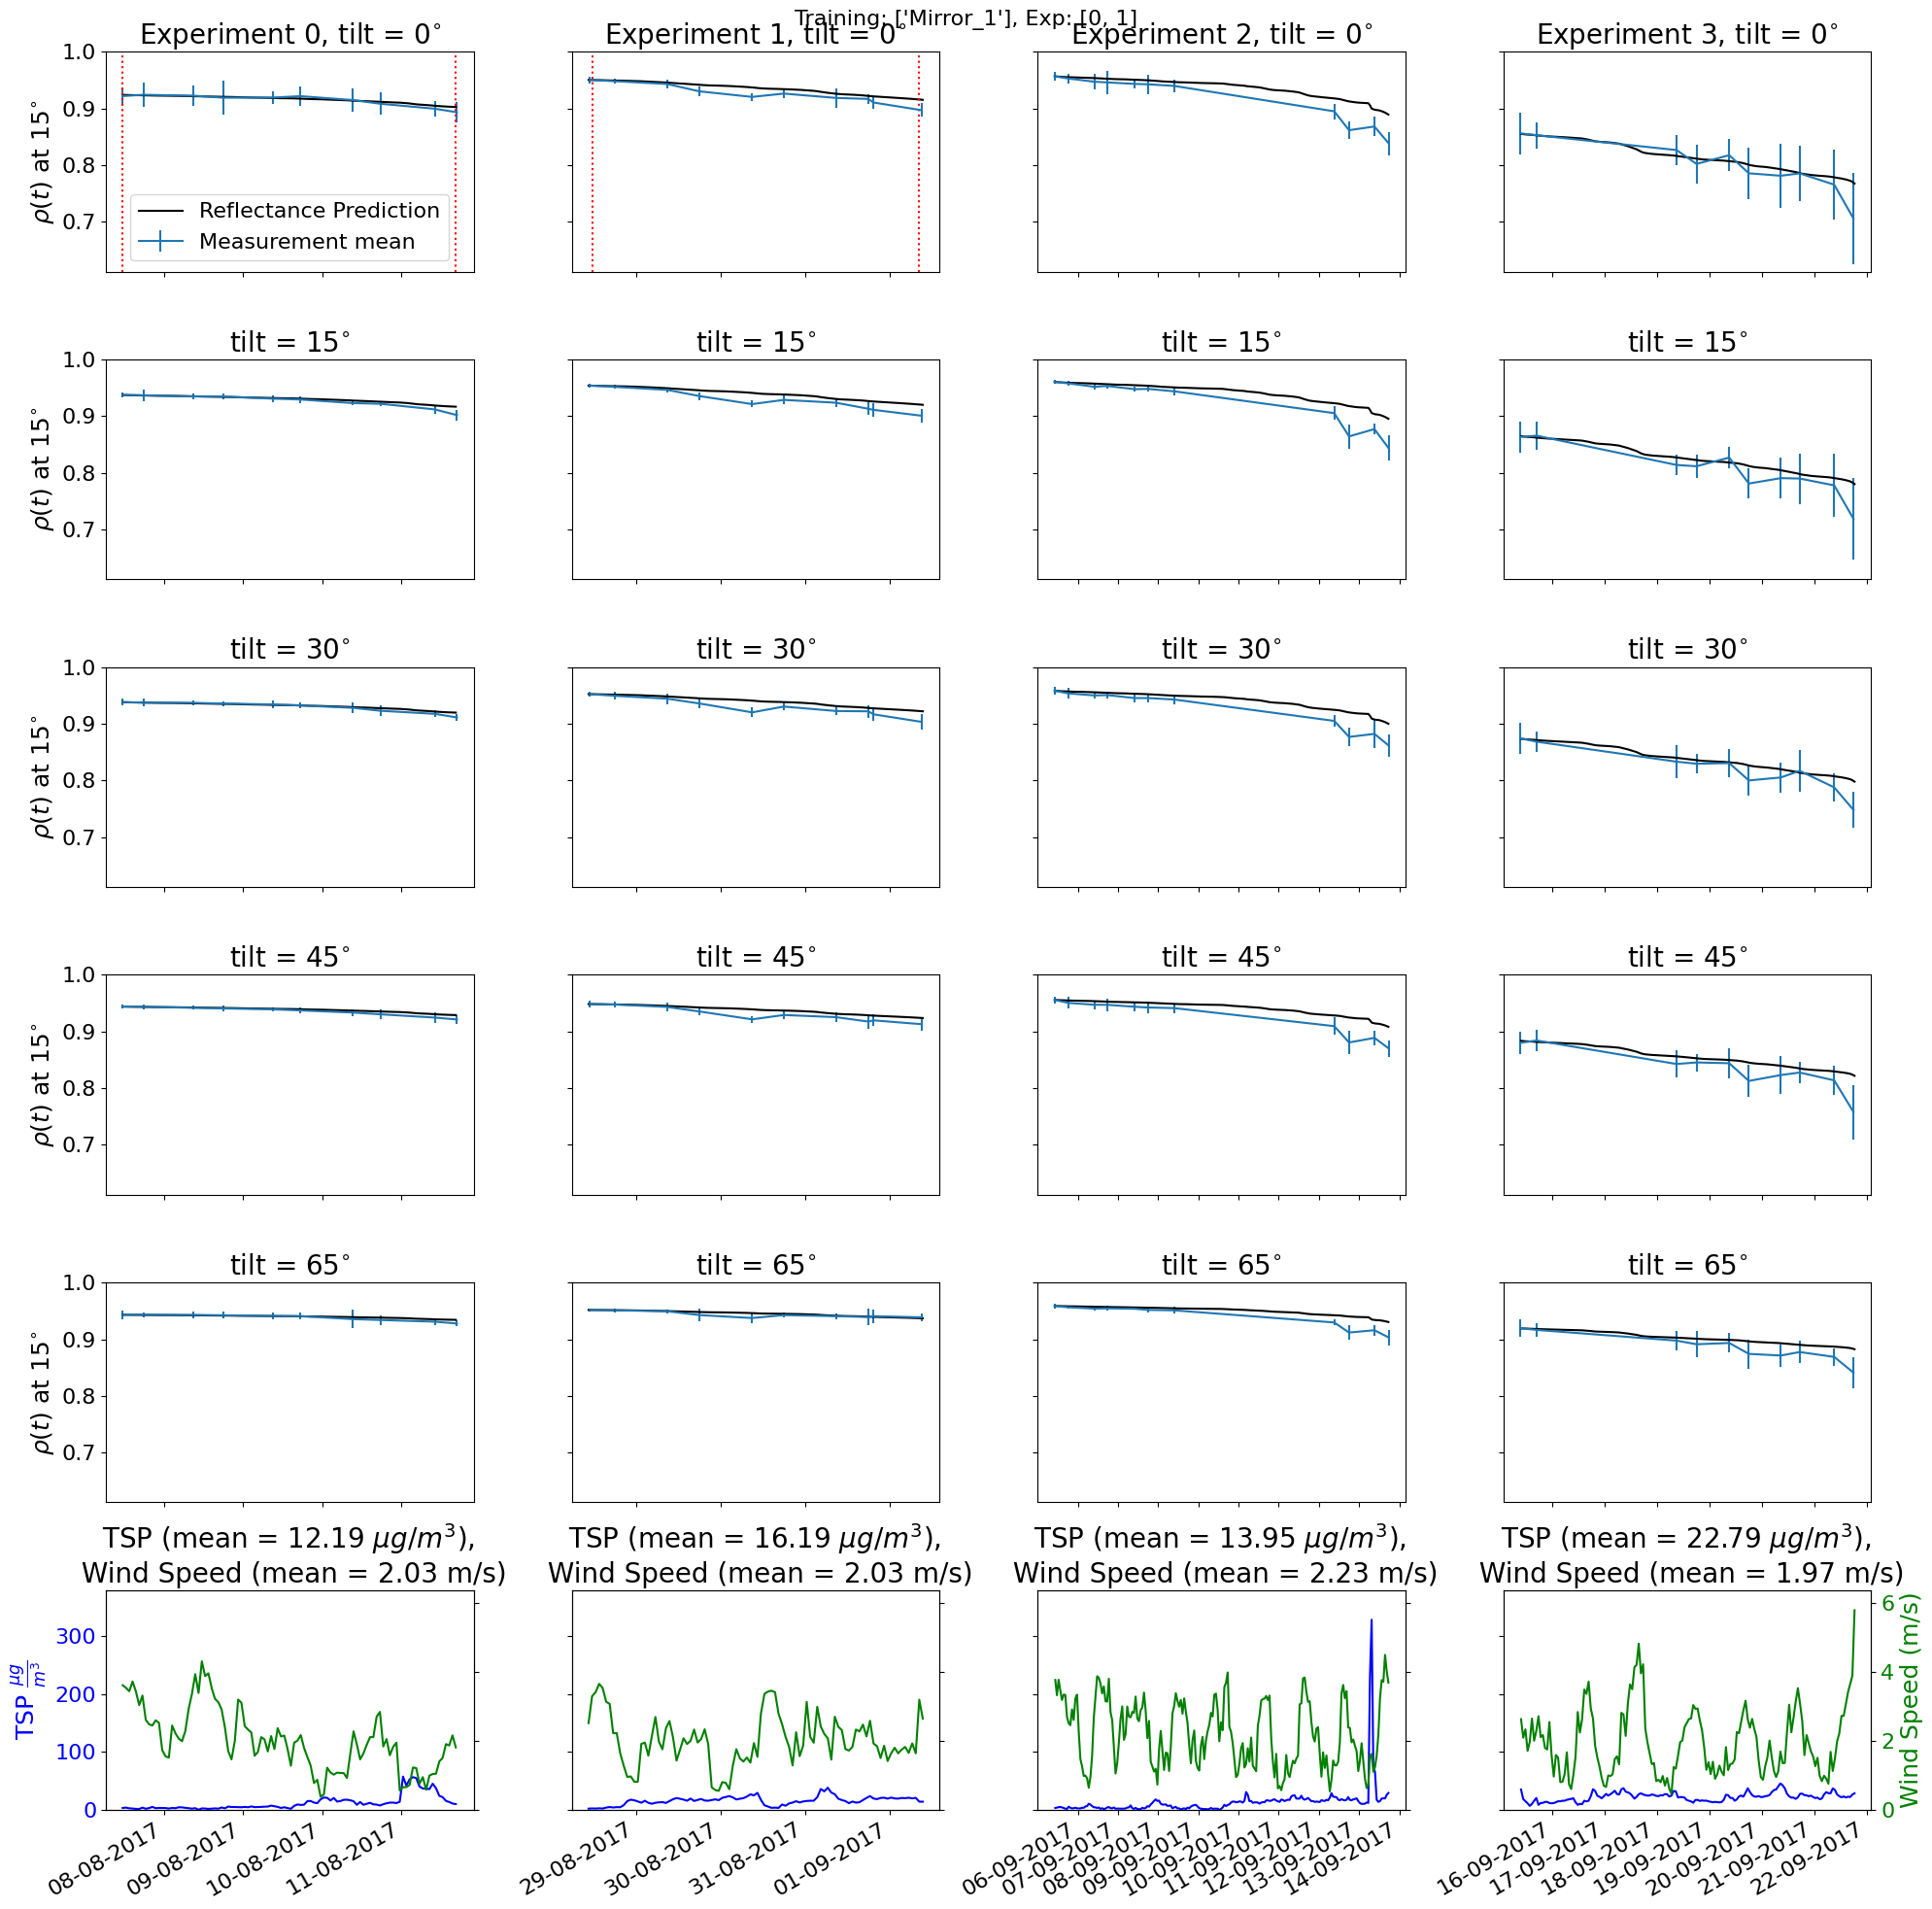

In [13]:
fig,ax,_,_,_  = imodel.plot_soiling_factor( sim_data_total,
                                            reflectance_data=reflect_data_total,
                                            figsize=(20,20),
                                            reflectance_std='measurements',
                                            fig_title=training_string,
                                            return_handles=True,
                                            repeat_y_labels=False)
# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax[jj,e]
            a.axvline(x=sim_data_train.time[ii].iloc[0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii].iloc[-1],ls=':',color='red')
fig.tight_layout()

# Parameter Estimation for the Stochastic Model

## Semi-physical model 

### Compute deposition velocity, angles, and Mie Extinction Weights

In [14]:
imodel.helios_angles(   sim_data_train,
                        reflect_data_train,
                        second_surface=second_surf)
                        
# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_train,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment_train))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

Setting tilts for 2 experiments
Second surface model
Second surface model


### Fitting
Maximum Likelihood Estmation (MLE) only for now

Getting initial deposition parameter guess via least squares
Getting initial sigma_dep guess via MLE (at least-squares value for deposition parameters)
x0 = [2.2286380015696627, 0.0002957603238395577]
Maximizing likelihood ...
  Optimization terminated successfully.
Estimating parameter covariance using numerical approximation of Hessian ... 
... done! 
log(log(hrz0)) = -4.61e-01, log(sigma_dep) = -8.15e+00
95% confidence interval for log(log(hrz0)): [-8.87e-01, -3.39e-02]
95% confidence interval for log(sigma_dep): [-8.65e+00, -7.64e+00]
... done!

log(log(hrz0)) = -4.61e-01, sigma_dep = -8.15e+00
95% confidence interval for log(log(hrz0)): [-8.87e-01, -3.39e-02]
95% confidence interval for log(sigma_dep): [-8.65e+00, -7.64e+00]
hrz0: 1.88e+00 [1.51e+00,2.63e+00]
\sigma_dep: 2.90e-04 [1.74e-04,4.81e-04] [p.p./day]
No value for hrz0 supplied. Using value in self.hrz0 = 1.8793474753109083.
Calculating deposition velocity for each of the 2 simulations
Aerodynamic resistance is considered

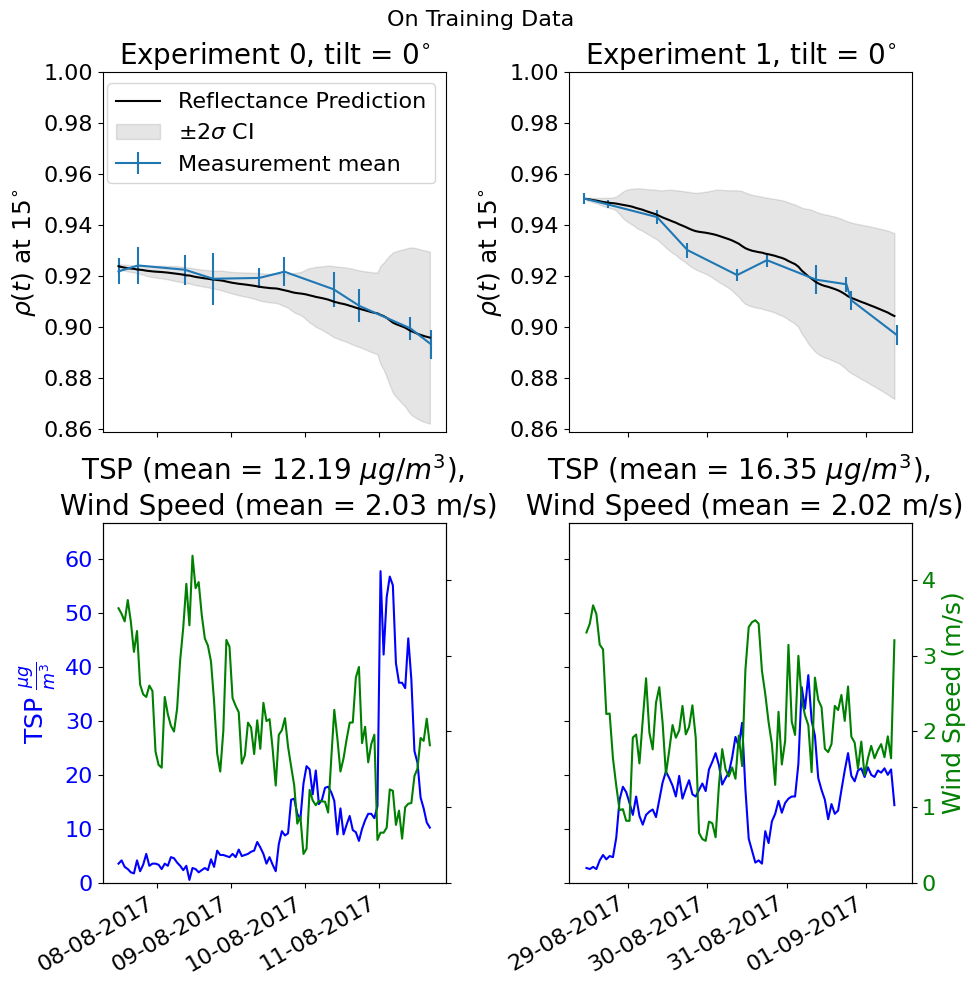

In [15]:

log_param_hat,log_param_cov = imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=False )

s = np.sqrt(np.diag(log_param_cov))
param_ci = log_param_hat + 1.96*s*np.array([[-1],[1]])
lower_ci = imodel.transform_scale(param_ci[0,:])
upper_ci = imodel.transform_scale(param_ci[1,:])
param_hat = imodel.transform_scale(log_param_hat)
hrz0_mle,sigma_dep_mle = param_hat
print(f'hrz0: {hrz0_mle:.2e} [{lower_ci[0]:.2e},{upper_ci[0]:.2e}]')
print(f'\sigma_dep: {sigma_dep_mle:.2e} [{lower_ci[1]:.2e},{upper_ci[1]:.2e}] [p.p./day]')

hrz0_mle,sigma_dep_mle = param_hat
imodel.update_model_parameters(param_hat)
imodel.save(sp_save_file,
            log_p_hat=log_param_hat,
            log_p_hat_cov=log_param_cov,
            training_simulation_data=sim_data_train,
            training_reflectance_data=reflect_data_train)

_,_,_ = imodel.plot_soiling_factor( sim_data_train,
                            reflectance_data=reflect_data_train,
                            figsize=(10,10),
                            reflectance_std='mean',
                            save_path="results/",
                            fig_title="On Training Data"    )

### Predict with test data and plot

In [16]:
imodel.helios_angles(   sim_data_total,
                        reflect_data_total,
                        second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_total,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


No value for hrz0 supplied. Using value in self.hrz0 = 1.8793474753109083.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


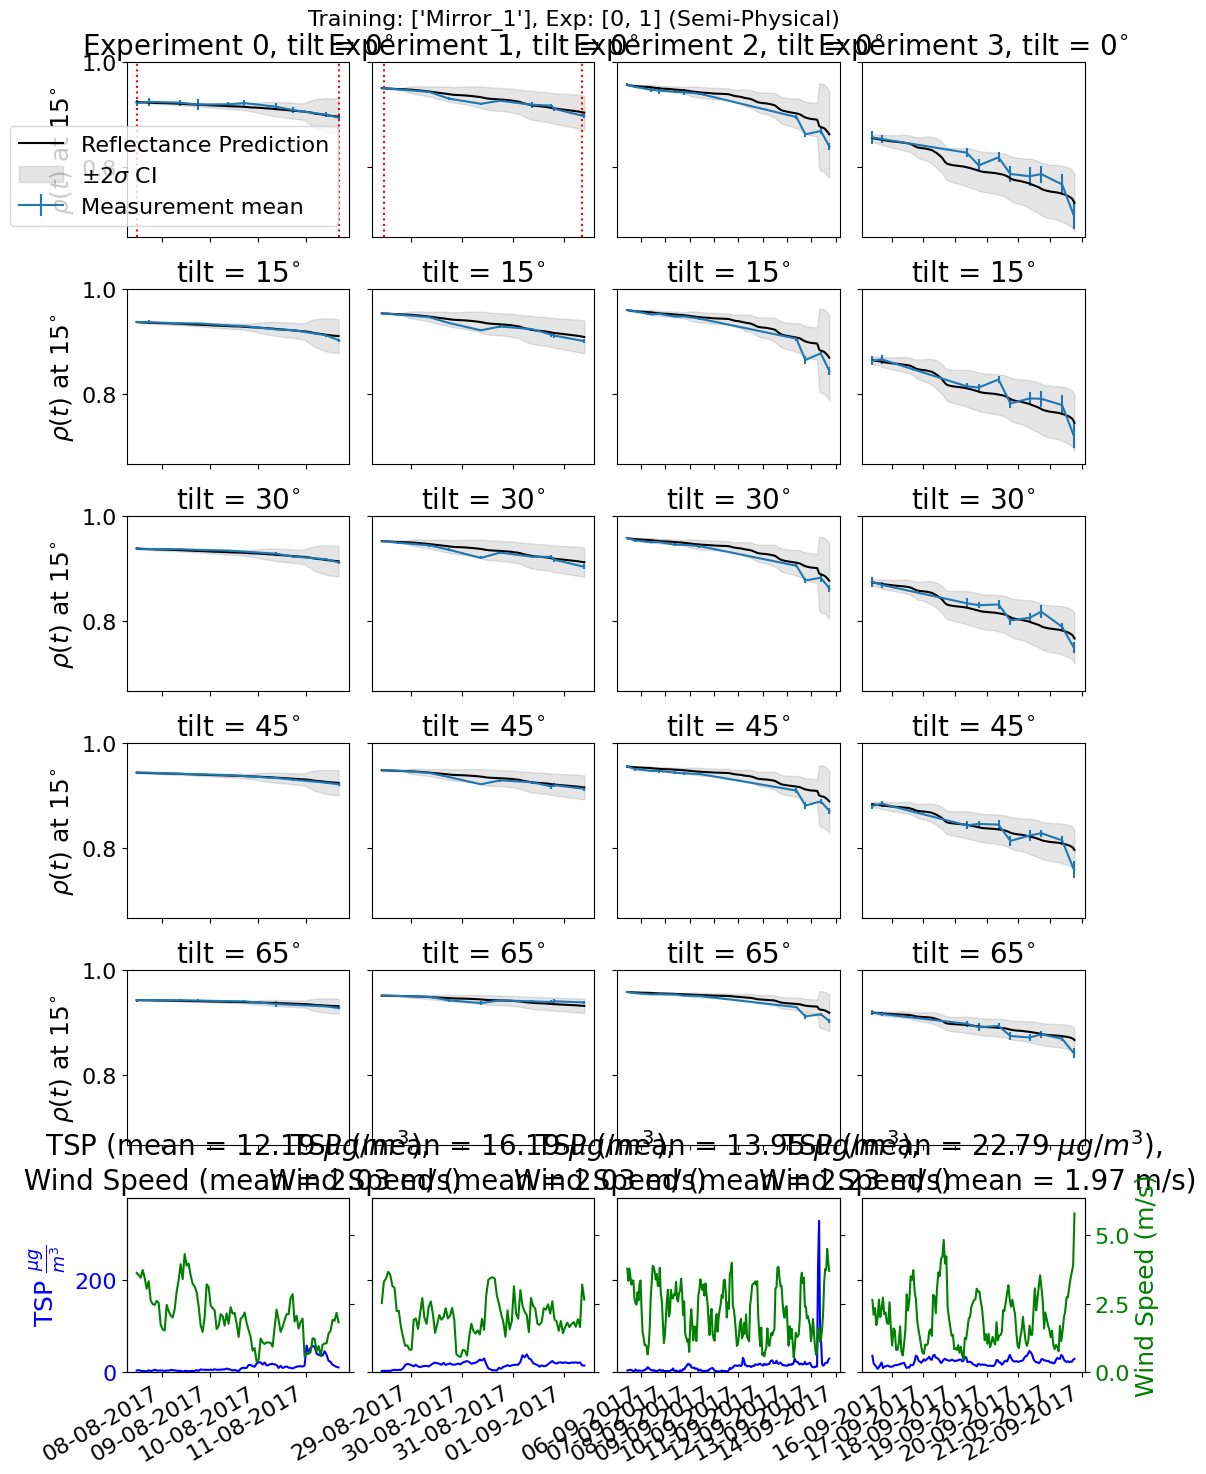

In [17]:
fig_total,ax_total,_,_,_   = imodel.plot_soiling_factor( sim_data_total,
                            reflectance_data=reflect_data_total,
                            figsize=(12,15),
                            reflectance_std='mean',
                            save_path="results/semi_physical_fitting.png",
                            fig_title=training_string+" (Semi-Physical)",
                            return_handles=True,
                            repeat_y_labels=False)

# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[jj,e]
            a.axvline(x=sim_data_train.time[ii].iloc[0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii].iloc[-1],ls=':',color='red')

fig_total.subplots_adjust(wspace=0.1, hspace=0.3)


## Normalized reflectance plot for paper

No value for hrz0 supplied. Using value in self.hrz0 = 1.8793474753109083.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


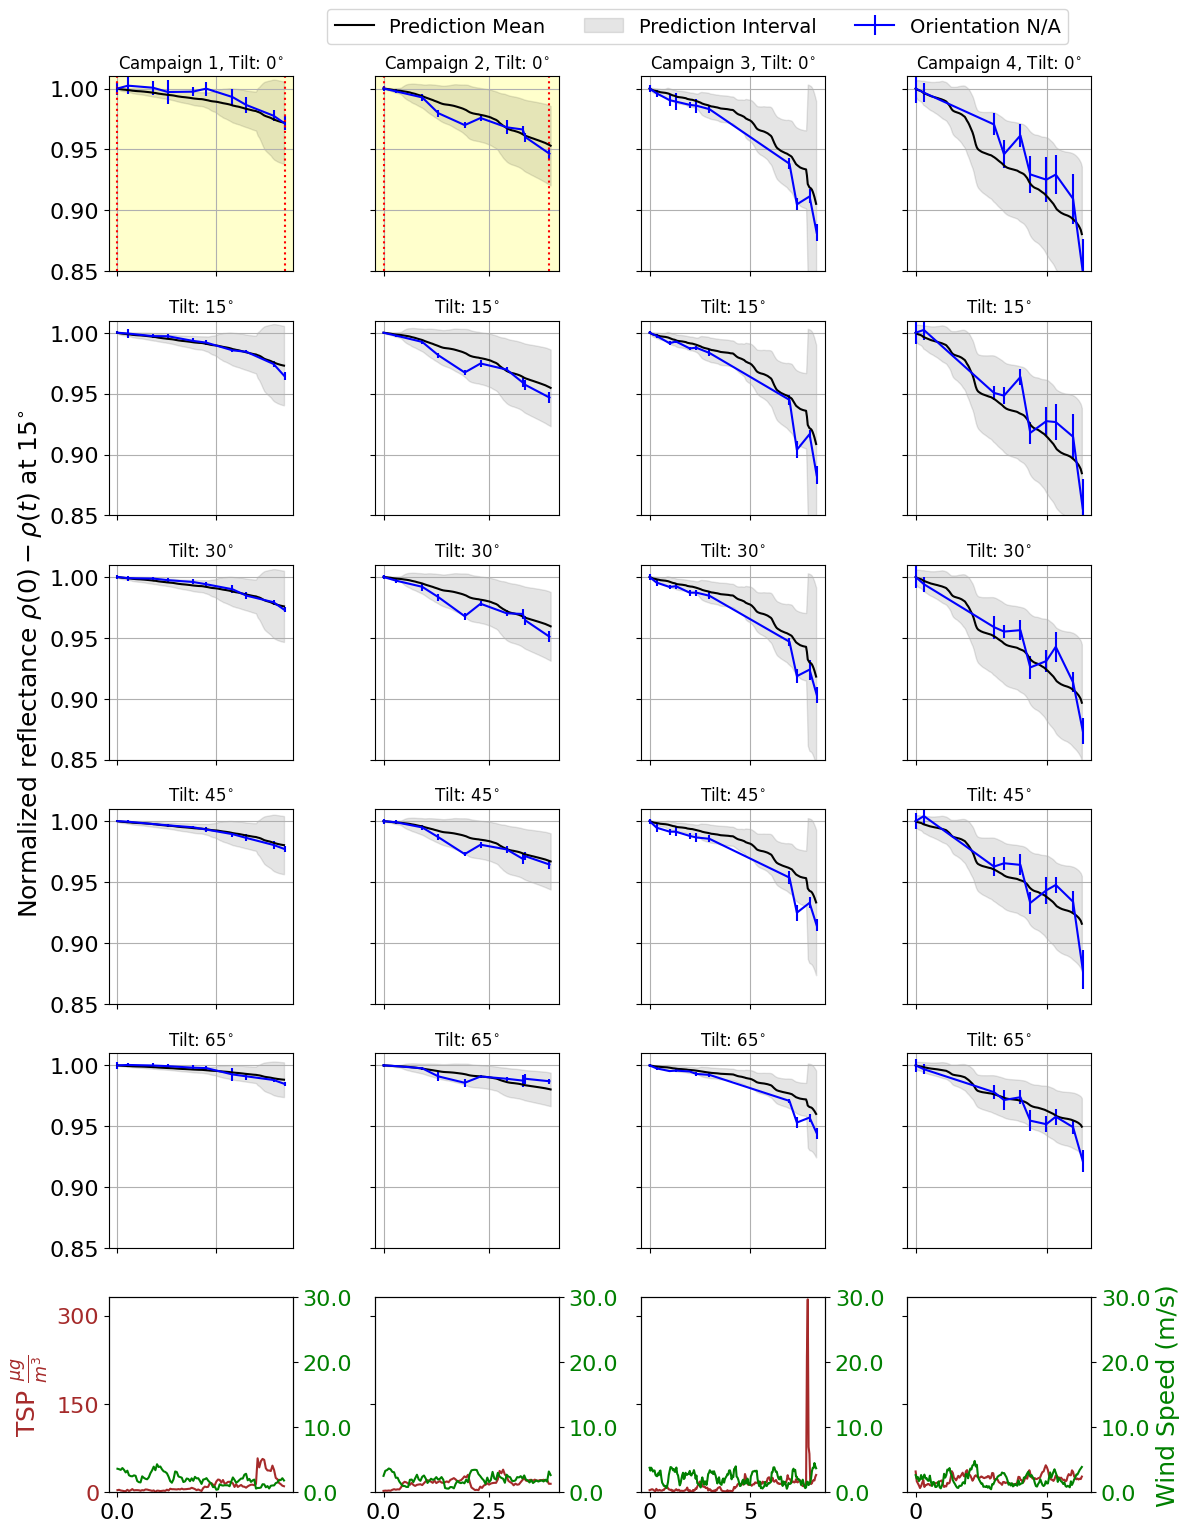

In [18]:
fig,ax,ref_output = plot_for_paper(    imodel,
                            reflect_data_total,
                            sim_data_total,
                            train_experiments,
                            train_mirrors,
                            [["N/A","N/A","N/A","N/A","N/A"] for m in range(4)], # note: these are not the actual orientations (the experimental values are actually the average of two orientations)
                            legend_shift=(0,0),
                            rows_with_legend=[2],
                            num_legend_cols=4,
                            plot_rh=False)
fig.savefig(sp_save_file+".pdf",bbox_inches='tight')

## Constant Mean Desposition Velocity
### Compute deposition velocity, angles. Mie weights not needed for constant mean model. 

In [19]:
constant_imodel = smf.ConstantMeanDeposition(parameter_file)
constant_imodel.helios_angles(  sim_data_train,
                                reflect_data_train,
                                second_surface=second_surf)

# extinction weights not needed for constant mean model


Loading data from data/qut/parameters_qut_experiments.xlsx ... 

Importing constants
No mu_tilde model defined in data/qut/parameters_qut_experiments.xlsx. You will need to define this before simulating
No sigma_dep model defined in data/qut/parameters_qut_experiments.xlsx.
Setting tilts for 2 experiments
Second surface model
Second surface model


### Fitting
MLE only for now

Getting MLE estimates ... 
========== MLE Estimates ======== 
log(mu_tilde) = -9.25e+00, log(sigma_dep) = -8.22e+00 
95% confidence interval for log(mu_tilde): [-9.79e+00, -8.72e+00]
95% confidence interval for log(sigma_dep): [-8.76e+00, -7.69e+00]
mu_tilde: 9.57e-05 [5.60e-05, 1.63e-04] [p.p./day]
\sigma_dep (constant mean model): 2.68e-04 [1.57e-04,4.57e-04] [p.p./day]
Calculating soil deposited in a timestep [m^2/m^2]


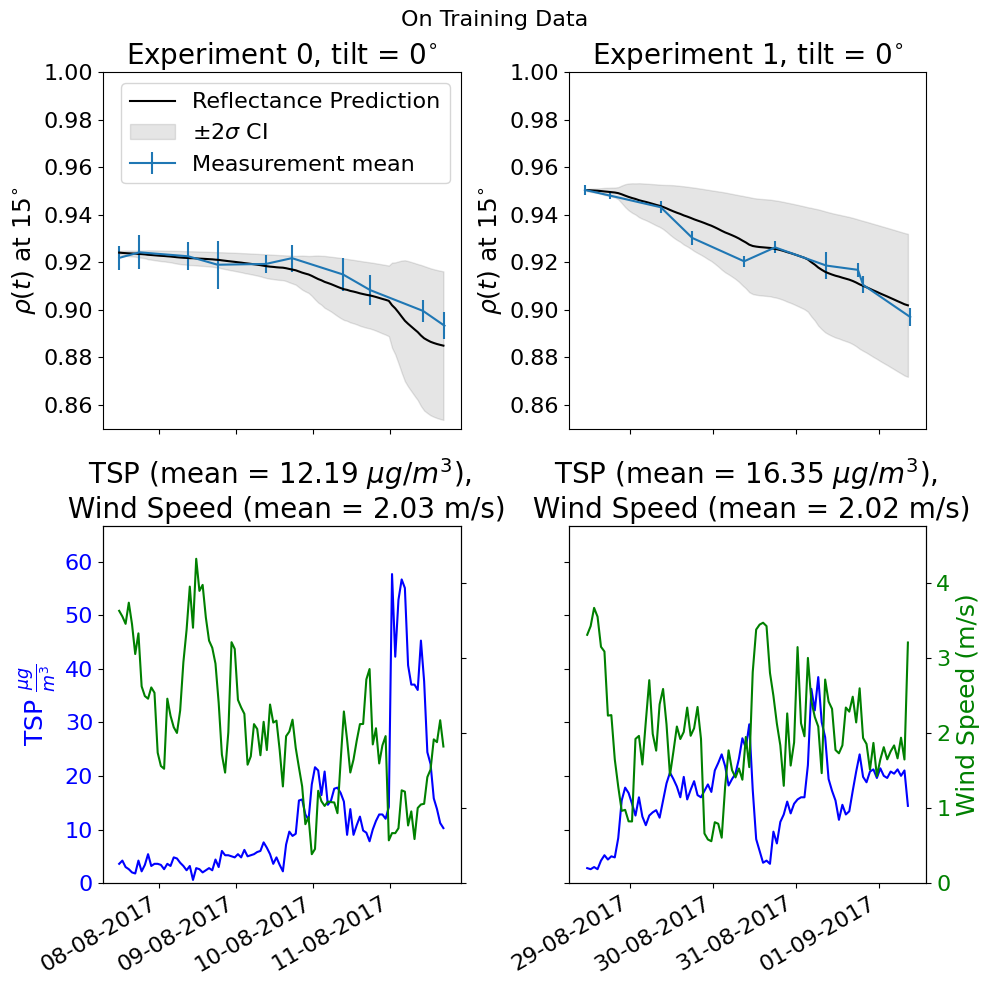

In [20]:
log_param_hat_con,log_param_cov_con = constant_imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=False)
constant_imodel.save(   cm_save_file,
                        log_p_hat=log_param_hat_con,
                        log_p_hat_cov=log_param_cov_con,
                        training_simulation_data=sim_data_train,
                        training_reflectance_data=reflect_data_train)

s_con = np.sqrt(np.diag(log_param_cov_con))
param_ci_con = log_param_hat_con + 1.96*s_con*np.array([[-1],[1]])
lower_ci_con = constant_imodel.transform_scale(param_ci_con[0,:])
upper_ci_con = constant_imodel.transform_scale(param_ci_con[1,:])
param_hat_con = constant_imodel.transform_scale(log_param_hat_con)
mu_tilde,sigma_dep_con = param_hat_con
print(f'mu_tilde: {mu_tilde:.2e} [{lower_ci_con[0]:.2e}, {upper_ci_con[0]:.2e}] [p.p./day]')
print(f'\sigma_dep (constant mean model): {sigma_dep_con:.2e} [{lower_ci_con[1]:.2e},{upper_ci_con[1]:.2e}] [p.p./day]')

constant_imodel.update_model_parameters(param_hat_con)
_,_,_ = constant_imodel.plot_soiling_factor(    sim_data_train,
                                        reflectance_data=reflect_data_train,
                                        figsize=(10,10),
                                        reflectance_std='mean',
                                        save_path="results/",
                                        fig_title="On Training Data"    )

### Predict with test data and plot

In [21]:
constant_imodel.helios_angles(  sim_data_total,
                                reflect_data_total,
                                second_surface=second_surf)

# Extinction weights not needed for constant mean model


Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


Calculating soil deposited in a timestep [m^2/m^2]


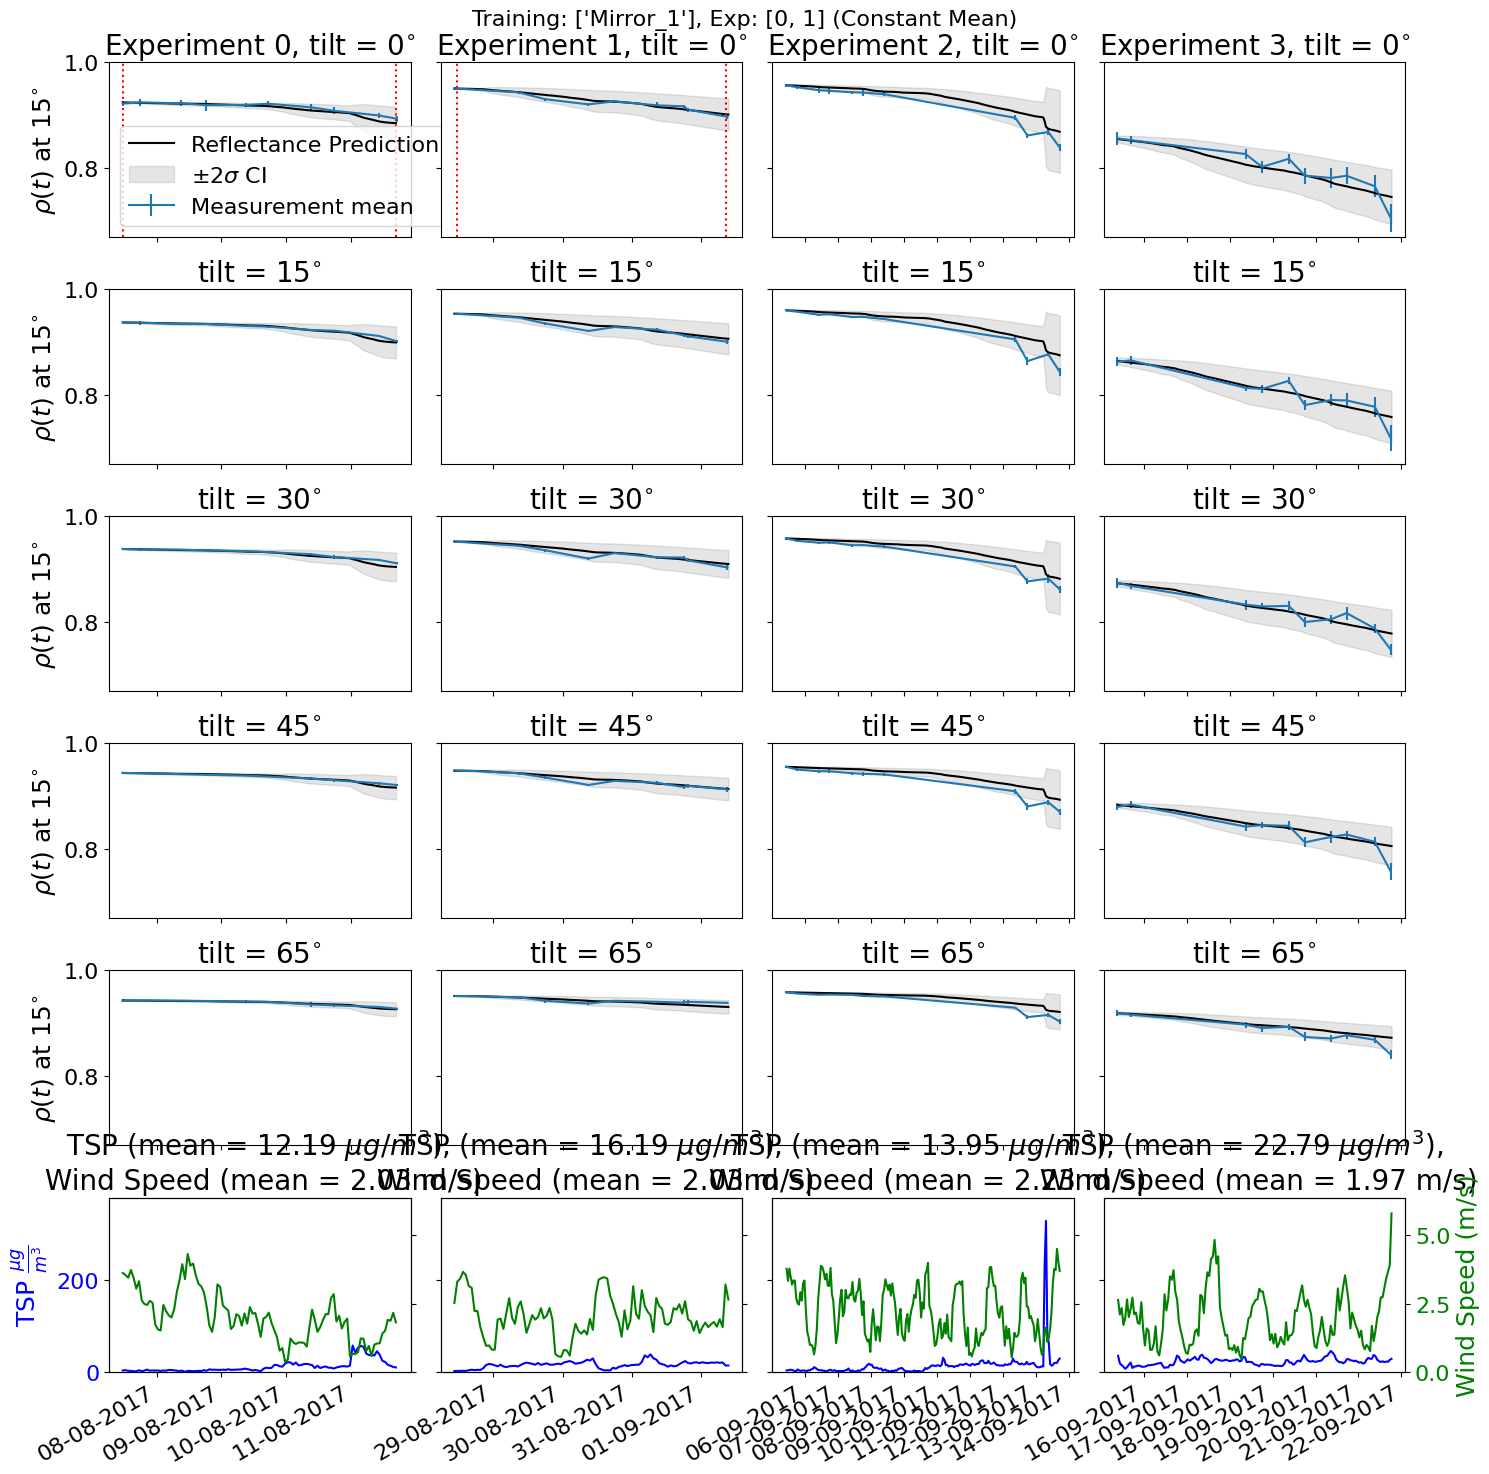

In [22]:
fig_total,ax_total,_,_,_   = constant_imodel.plot_soiling_factor(   sim_data_total,
                                                                    reflectance_data=reflect_data_total,
                                                                    figsize=(15,15),
                                                                    reflectance_std='mean',
                                                                    save_path="results/constant_mean_fitting.png",
                                                                    fig_title=training_string+" (Constant Mean)",
                                                                    return_handles=True,
                                                                    repeat_y_labels=False)

# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[jj,e]
            a.axvline(x=sim_data_train.time[ii].iloc[0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii].iloc[-1],ls=':',color='red')

fig_total.subplots_adjust(wspace=0.1, hspace=0.3)


## Normalized reflectance plots for the paper

Calculating soil deposited in a timestep [m^2/m^2]


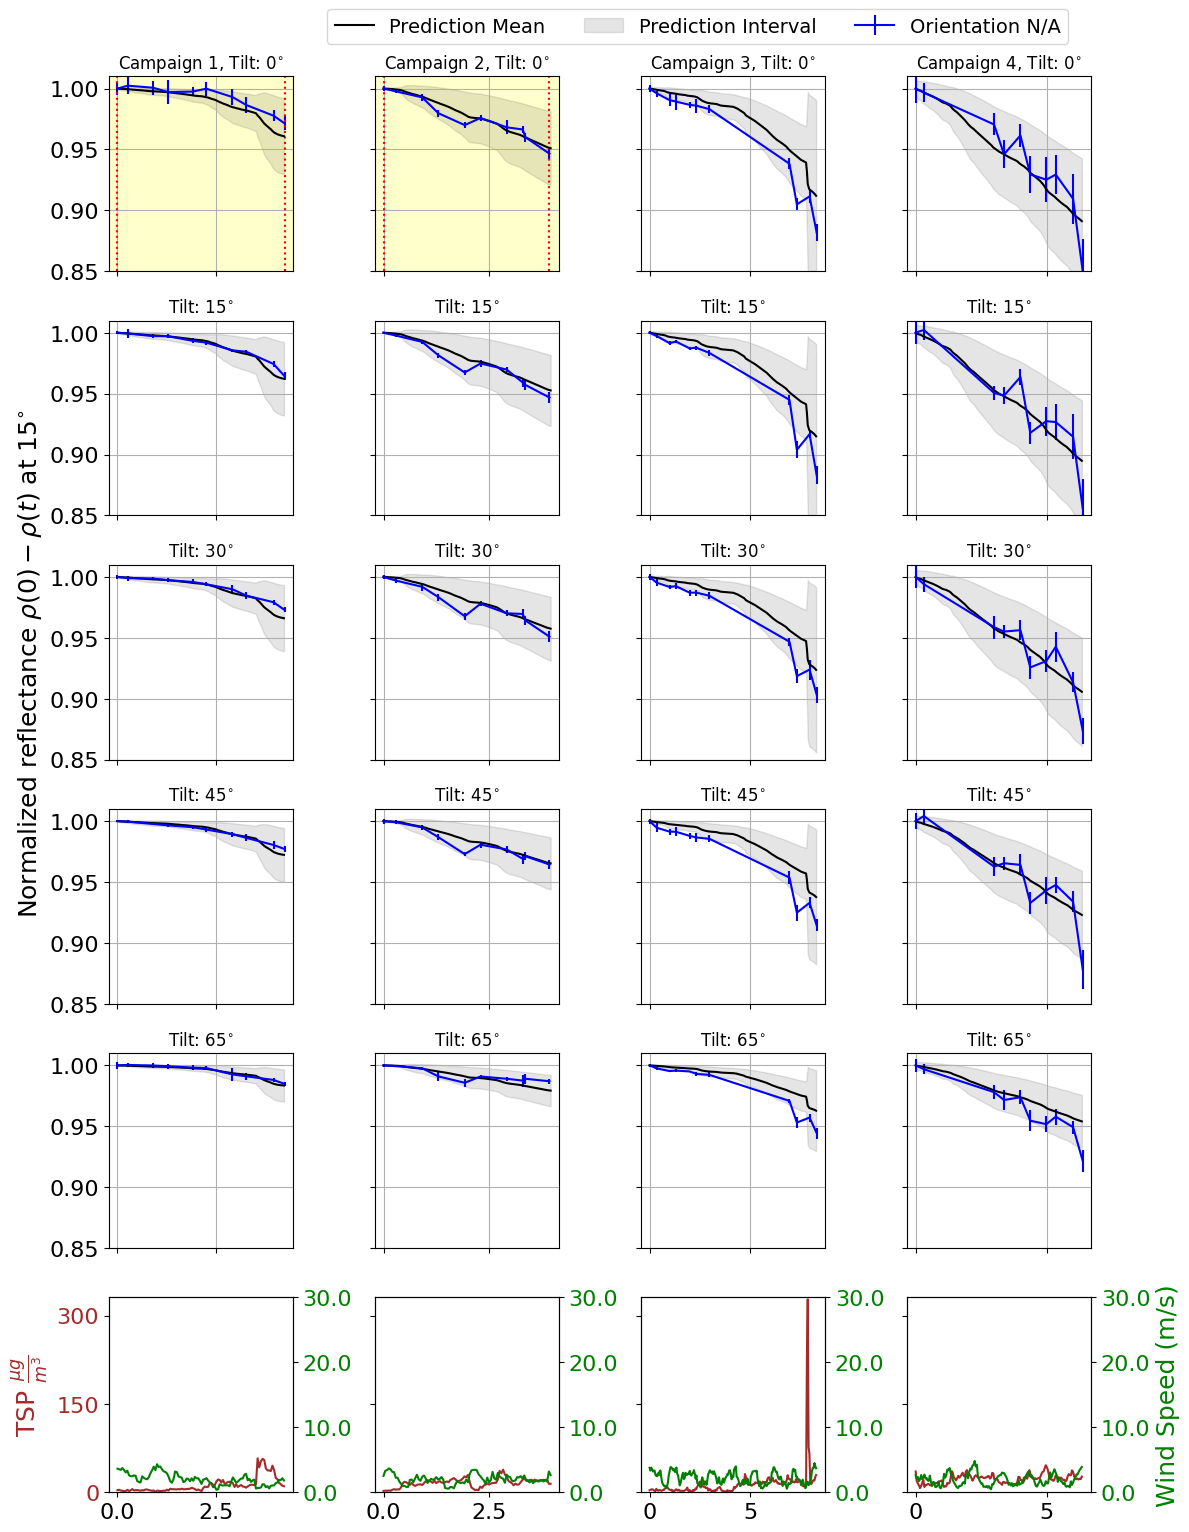

In [23]:
fig,ax,_ = plot_for_paper(    constant_imodel,
                            reflect_data_total,
                            sim_data_total,
                            train_experiments,
                            train_mirrors,
                            [["N/A","N/A","N/A","N/A","N/A"] for m in range(4)], # note: these are not the actual orientations (the experimental values are actually the average of two orientations)
                            legend_shift=(0,0),
                            rows_with_legend=[2],
                            num_legend_cols=4,
                            plot_rh=False)
fig.savefig(cm_save_file+".pdf",bbox_inches='tight')

## High, Medium, Low daily loss distributions from total data

C:\Users\cholette\AppData\Local\Temp\ipykernel_29884\1012445449.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  sims,a,a2 = daily_soiling_rate(  sim_data_total,


Loss for Low scenario: 0.07 +/- 0.11
Loss for Medium scenario: 0.53 +/- 0.66
Loss for High scenario: 0.92 +/- 1.04
Loss for Maximum scenario: 1.29 +/- 3.18


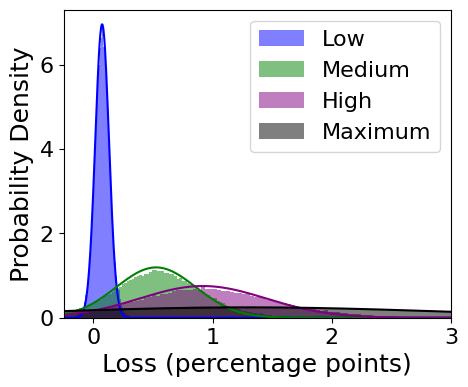

In [24]:
pers = [5,50,95.0,100]
labels = ['Low','Medium','High','Maximum']
colors = ['blue','green','purple','black']
fsz=16

sims,a,a2 = daily_soiling_rate(  sim_data_total,
                            cm_save_file,
                            M = 100000,
                            percents=pers,
                            dust_type=dust_type)
# xL,xU = np.percentile(sims,[0.1,99.9])
xL,xU = -0.25,3.0
lg = np.linspace(xL,xU,1000)
inc_factor = imodel.helios.inc_ref_factor[0]

fig,ax = plt.subplots()
for ii in range(sims.shape[1]):
    ax.hist(sims[:,ii],250,density=True,
            alpha=0.5,color=colors[ii],
            label=labels[ii])

    loc = inc_factor*mu_tilde*a[ii]
    s2 = (inc_factor*sigma_dep_con)**2 * a2[ii]
    dist = sps.norm(loc=loc*100,scale=np.sqrt(s2)*100)
    ax.plot(lg,dist.pdf(lg),color=colors[ii])
    print(f"Loss for {labels[ii]} scenario: {loc*100:.2f} +/- {1.96*100*np.sqrt(s2):.2f}")

ax.set_xlim((xL,xU))
ax.set_ylabel('Probability Density',fontsize=fsz+2)
ax.set_xlabel('Loss (percentage points)',fontsize=fsz+2)
ax.legend(fontsize=fsz)

fig.set_size_inches(5,4)
fig.savefig("./results/losses_qut.pdf",dpi=300,bbox_inches='tight',pad_inches=0)

# Fit Quality Assessments

1
min_loss=-0.5850000000000355,max_loss=6.0
2
min_loss=-1.024999999999976,max_loss=6.0
3
min_loss=-1.5399999999999747,max_loss=6.0


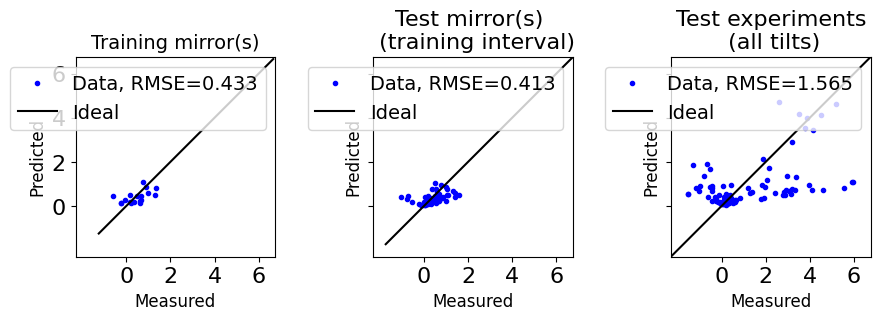

In [25]:
# %% Fit quality plots (semi-physical)
mirror_idxs = list(range(len(all_mirrors)))
test_experiments = [f for f in list(range(len(files_experiment))) if f not in train_experiments]
train_mirror_idx = [m for m in mirror_idxs if all_mirrors[m] in train_mirrors]
test_mirror_idx = [m for m in mirror_idxs if all_mirrors[m] not in train_mirrors]

fig,ax = summarize_fit_quality( imodel,
                                reflect_data_total,
                                train_experiments,
                                train_mirror_idx,
                                test_mirror_idx,test_experiments,
                                min_loss=-0.2,
                                max_loss=6.0,
                                save_file=sp_save_file,
                                figsize=(10,10),
                                include_fits=False
                                )
for a in ax:
    a.set_xticks([0,2,4,6])
    a.set_yticks([0,2,4,6])

file index: 2
file index: 3
min_loss=-2.0,max_loss=15.0
file index: 0
file index: 1
min_loss=-2.0,max_loss=15.0
file index: 0
file index: 1
min_loss=-2.0,max_loss=15.0
min_loss=-2.0,max_loss=6.0
min_loss=-2.0,max_loss=6.0
min_loss=-2.0,max_loss=6.0


Text(0.5, 1.0, 'Loss change prediction quality assessment (semi-physical)')

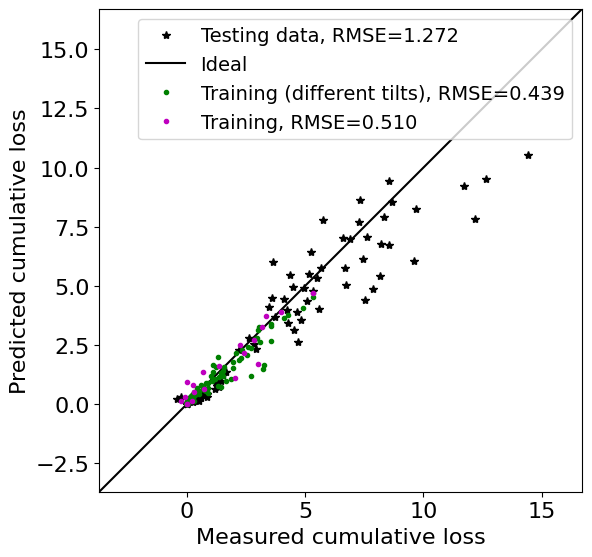

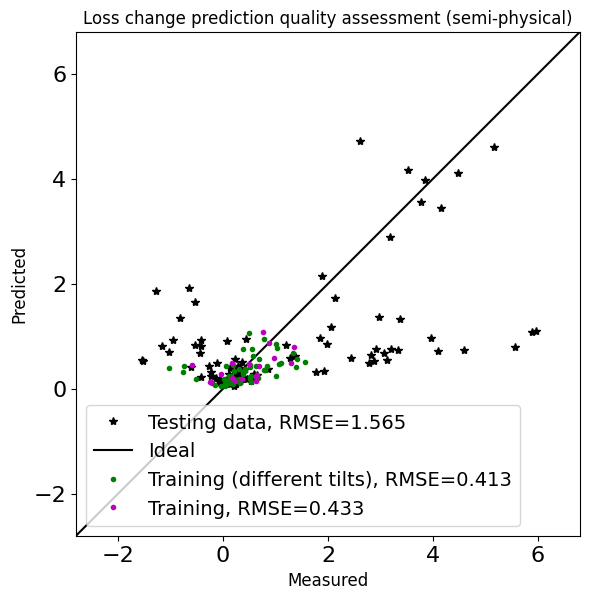

In [26]:
fig,ax = plt.subplots(figsize=(6,6))
fit_quality_plots(imodel,
                  reflect_data_total,
                  test_experiments,
                  test_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=15.0,
                  include_fits=False,
                  data_ls='k*',
                  data_label="Testing data",
                  replot=True,
                  vertical_adjust=-0.1,
                  cumulative=True)

fit_quality_plots(imodel,
                  reflect_data_total,
                  train_experiments,
                  test_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=15.0,
                  include_fits=False,
                  data_ls='g.',
                  data_label="Training (different tilts)",
                  replot=False,
                  vertical_adjust=-0.05,
                  cumulative=True)

fit_quality_plots(imodel,
                  reflect_data_total,
                  train_experiments,
                  train_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=15.0,
                  include_fits=False,
                  data_ls='m.',
                  replot=False,
                  data_label="Training",
                  cumulative=True)


ax.set_xlabel("Measured cumulative loss",fontsize=16)
ax.set_ylabel("Predicted cumulative loss",fontsize=16)
fig.savefig(sp_save_file+"_cumulative_fit_quality.pdf",bbox_inches='tight')

fig,ax = plt.subplots(figsize=(6,6))
fit_quality_plots(imodel,
                  reflect_data_total,
                  test_experiments,
                  test_mirror_idx+train_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=6.0,
                  include_fits=False,
                  data_ls='k*',
                  data_label="Testing data",
                  replot=True,
                  vertical_adjust=-0.1,
                  cumulative=False)

fit_quality_plots(imodel,
                  reflect_data_total,
                  train_experiments,
                  test_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=6.0,
                  include_fits=False,
                  data_ls='g.',
                  data_label="Training (different tilts)",
                  replot=False,
                  vertical_adjust=-0.05,
                  cumulative=False)

fit_quality_plots(imodel,
                  reflect_data_total,
                  train_experiments,
                  train_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=6.0,
                  include_fits=False,
                  data_ls='m.',
                  replot=False,
                  data_label="Training",
                  cumulative=False)



ax.set_title("Loss change prediction quality assessment (semi-physical)")

1
min_loss=-2.0,max_loss=6.0
2
min_loss=-2.0,max_loss=6.0
3
min_loss=-2.0,max_loss=6.0


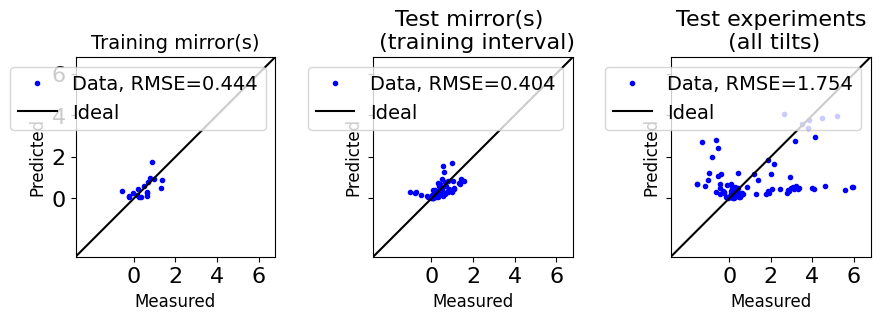

In [27]:
# %% Fit Quality plots (constant-mean)
fig,ax = summarize_fit_quality( constant_imodel,
                                reflect_data_total,
                                train_experiments,
                                train_mirror_idx,
                                test_mirror_idx,test_experiments,
                                min_loss=-2,
                                max_loss=6.0,
                                save_file=sp_save_file,
                                figsize=(10,10),
                                include_fits=False)
for a in ax:
    a.set_xticks([0,2,4,6])
    a.set_yticks([0,2,4,6])

file index: 2
file index: 3
min_loss=-2.0,max_loss=15.02000000000001
file index: 0
file index: 1
min_loss=-2.0,max_loss=15.0
file index: 0
file index: 1
min_loss=-2.0,max_loss=15.0
min_loss=-2.0,max_loss=6.0
min_loss=-2.0,max_loss=6.0
min_loss=-2.0,max_loss=6.0


Text(33.0, 0.5, 'Predicted $\\Delta$loss')

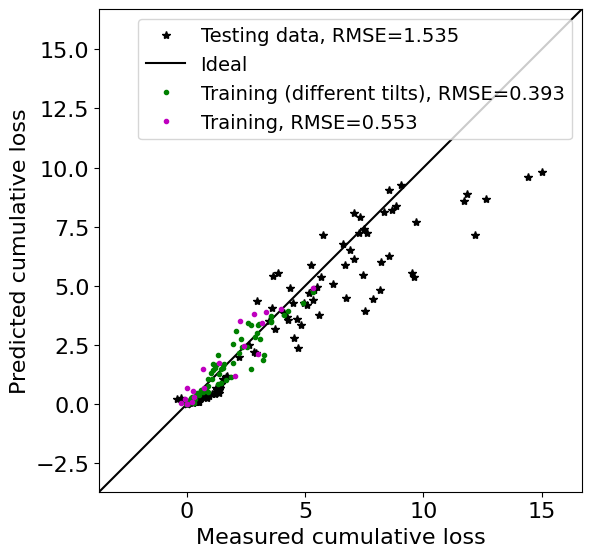

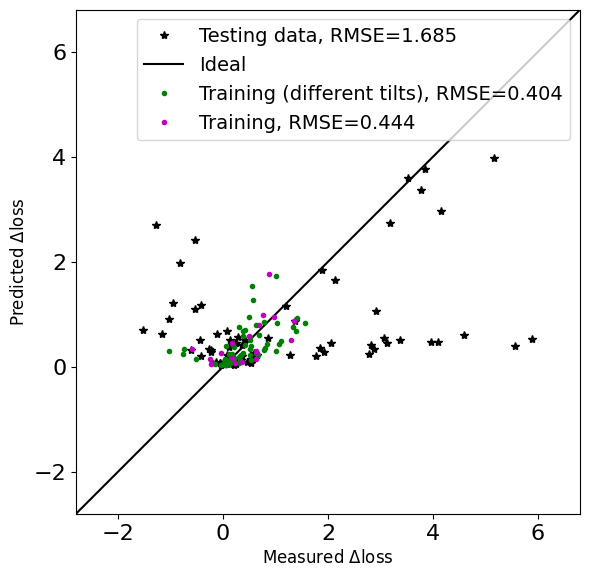

In [28]:
fig,ax = plt.subplots(figsize=(6,6))

fit_quality_plots(constant_imodel,
                  reflect_data_total,
                  test_experiments,
                  test_mirror_idx+train_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=15.0,
                  include_fits=False,
                  data_ls='k*',
                  data_label="Testing data",
                  replot=True,
                  vertical_adjust=-0.1,
                  cumulative=True)

fit_quality_plots(constant_imodel,
                  reflect_data_total,
                  train_experiments,
                  test_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=15.0,
                  include_fits=False,
                  data_ls='g.',
                  data_label="Training (different tilts)",
                  replot=False,
                  vertical_adjust=-0.05,
                  cumulative=True)

fit_quality_plots(constant_imodel,
                  reflect_data_total,
                  train_experiments,
                  train_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=15.0,
                  include_fits=False,
                  data_ls='m.',
                  replot=False,
                  data_label="Training",
                  cumulative=True)

ax.set_xlabel("Measured cumulative loss",fontsize=16)
ax.set_ylabel("Predicted cumulative loss",fontsize=16)
fig.savefig(cm_save_file+"_cumulative_fit_quality.pdf",bbox_inches='tight')

fig,ax = plt.subplots(figsize=(6,6))
fit_quality_plots(constant_imodel,
                  reflect_data_total,
                  test_experiments,
                  test_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=6.0,
                  include_fits=False,
                  data_ls='k*',
                  data_label="Testing data",
                  replot=True,
                  vertical_adjust=-0.1,
                  cumulative=False)

fit_quality_plots(constant_imodel,
                  reflect_data_total,
                  train_experiments,
                  test_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=6.0,
                  include_fits=False,
                  data_ls='g.',
                  data_label="Training (different tilts)",
                  replot=False,
                  vertical_adjust=-0.05,
                  cumulative=False)

fit_quality_plots(constant_imodel,
                  reflect_data_total,
                  train_experiments,
                  train_mirror_idx,
                  ax=ax,
                  min_loss= -2,
                  max_loss=6.0,
                  include_fits=False,
                  data_ls='m.',
                  replot=False,
                  data_label="Training",
                  cumulative=False)

# ax.set_title("Loss change prediction quality assessment (constant mean)")
ax.set_xlabel(r"Measured $\Delta$loss")
ax.set_ylabel(r"Predicted $\Delta$loss")

